In [1]:
#import libraries and datasets
from IPython import display
import math

import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch import amp
import gc

from customDataset import ImgTripletDataset
from atdloader import ATD12KDataset
import networks
from networks import IDiscriminator, Generator


img_height = 32
img_width = 32

compose = transforms.Compose(
    [
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
dataset = ImgTripletDataset(root_dir = './dataset/vimeo_triplet/sequences', csv_file = './tri_trainlist.csv', transform=compose)
dataset2 = ATD12KDataset(root_dir = './dataset/datasets/train_10k/', transform=compose)
batch_size = 128

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
data_loader2 = DataLoader(dataset=dataset2, batch_size=batch_size, shuffle=True)

num_batches = len(data_loader)
num_batches2 = len(data_loader2)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

d_E = 32
hidden_size=100
seq_length=3

#functions to show images
def tensor2numpy(x):
    return "%.3f" % x.mean().detach().cpu().numpy()

def show_images(images, title=""):
    fig, axes = plt.subplots(1, 4, figsize=(8, 2*32))
    fig.suptitle("", fontsize=20)
    
    for j in range(4):
        img = images[j][0].detach()
        img = img.permute(1, 2, 0)
        img = img.cpu()
        img = torch.clamp(img, 0, 1).numpy()

        axes[j].axis("off")
        axes[j].imshow(img)

    plt.tight_layout()
    plt.show()

using cuda


In [2]:
def noise(size):
    n = Variable(torch.randn(batch_size, size))
    if torch.cuda.is_available(): return n.cuda()

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
        
#create models
#init weights and create networks
generator = Generator(batch_size, img_width, img_height)
generator.apply(init_weights)
img_disc = IDiscriminator()
img_disc.apply(init_weights)

#use cuda if available
if torch.cuda.is_available():
    generator.cuda()
    img_disc.cuda()

#optimizers
lr = 3e-4
betas=(0.5, 0.999)
d_opt = Adam(img_disc.parameters(), lr=0.00015, betas=betas)
g_opt = Adam(generator.parameters(), lr=0.0003, betas=betas)

#epochs
num_epochs = 10

In [3]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1)*0.9)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [4]:
g_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
lambd = 0.002
lambd2 = 0.0002
d_loss = nn.BCELoss()

#train generator
def TG(optimizer, fr_true, gen_frames):
    optimizer.zero_grad()
    
    #calculate loss for fake data, minimize distance to 0
    # noise = 0.25*torch.randn_like(fr_true).cuda()
    # gen_frames = gen_frames + noise
    i_prediction = img_disc(gen_frames)
    i_rdt = fake_data_target(fr_true.size(0))
    # i_error = g_loss(fr_true, gen_frames) + lambd*d_los s(i_prediction, i_rdt)
    i_error = l1_loss(fr_true, gen_frames) + lambd*(-torch.mean(i_prediction))
    i_error.backward()
        
    optimizer.step()
    return i_error

#train image discriminator
def TID(optimizer, real, fake):
    optimizer.zero_grad()
    
    #calculate loss for real data, minimize distance to 0
    noise = torch.randn_like(real).cuda()
    # real = real + noise
    # real = Variable(real)
    prediction_real = img_disc(real)
    rdt = real_data_target(real.size(0))
    error_real = d_loss(prediction_real, rdt)
    # error_real.backward()
    #calculate loss for fake data, minimize distance to 1
    noise = torch.randn_like(fake).cuda()
    # prediction_fake = img_disc(fake+noise)
    prediction_fake = img_disc(fake)
    fdt = fake_data_target(fake.size(0))
    # error_fake = d_loss(prediction_fake, fdt)
    # error_fake.backward()
    # error = (error_fake + error_real)
    error = -torch.mean(prediction_real) + torch.mean(prediction_fake)
    error.backward()
    
    #update weights
    optimizer.step()
    #return predictions
    return error, prediction_real, prediction_fake

epoch 2/10 iter/epoch 30/388
d_error -0.000 gi_error 0.121 d_pred_real 0.000 d_pred_fake 0.000


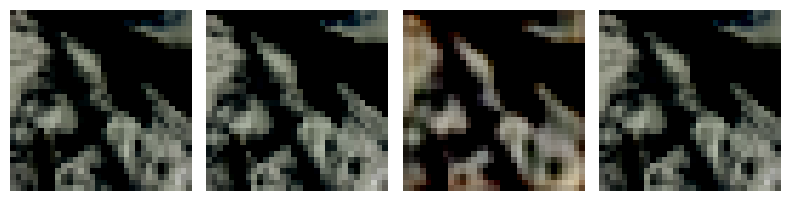

1/10 

KeyboardInterrupt: 

In [5]:
#train network and display results
nz = 100
udt= 10

def save_models():
    torch.save(generator.state_dict(), './models/generator.pth')
    torch.save(img_disc.state_dict(), './models/discriminator.pth')
    
def overlay_images(img1, img2, alpha=0.5):
    return (alpha * img1 + (1 - alpha) * img2).clamp(0, 1)

# usePrevModel = True
usePrevModel = False
if usePrevModel:
    generator.load_state_dict(torch.load('./models/generator.pth'))

iterator2 = iter(data_loader2)

for epoch in range(num_epochs):
    for bi, (real_batch, _) in enumerate(data_loader):
        if(bi % 64 == 0):
            real_batch2 = next(iterator2)  # Get the batch after advancing
            real_batch = real_batch2
        fr_beg = real_batch[0].cuda()
        fr_mid = real_batch[1].cuda()
        fr_end = real_batch[2].cuda()
        
        #overlay start and end frames
        if(fr_beg.shape != fr_end.shape): continue
        comb_batch = torch.stack([overlay_images(fr_beg[i], fr_end[i]) for i in range(len(fr_mid))]).cuda()

        #generate fake images
        # noise_batch = comb_batch + 0.25*torch.randn_like(comb_batch)
        gen_frames = generator(comb_batch)
        # print(gen_frames.shape)
        gen_frames = gen_frames.detach()
        
        #train discriminators
        d_error, d_pred_real, d_pred_fake = TID(d_opt, fr_mid, gen_frames)

        #train generators
        # comb_batch = comb_batch + torch.randn_like(comb_batch)
        gen_frames = generator(comb_batch)
        gi_error = TG(g_opt, fr_mid, gen_frames)
        
        #print training results
        if (bi) % udt == 0:
            new_frame = generator(comb_batch[0].unsqueeze(0))
            images = (fr_beg, fr_end, new_frame, fr_mid)
            display.clear_output(True)
            print(
                "epoch %d/%d" % (epoch,num_epochs), 
                "iter/epoch %d/%d" % (bi, num_batches),
            )
            # Display errors
            print(
                "d_error", tensor2numpy(d_error), 
                "gi_error", tensor2numpy(gi_error), 
                "d_pred_real", tensor2numpy(d_pred_real), 
                "d_pred_fake", tensor2numpy(d_pred_fake)
            )

            show_images(images)
            
        print(f"\r{bi%udt}/{udt}", end = " ")
    if epoch % 2 == 1:
        save_models()
        torch.cuda.empty_cache()
        gc.collect()
save_models()